In [1]:
import numpy as np
import pandas as pd
import mysql.connector
import json
from datetime import datetime, timedelta, date

### Getting data From SQL table

In [2]:
db = input()

legacyFood


In [3]:
mydb = mysql.connector.connect(
                                user = '',
                                host = '',
                                password = '',
                                database = db
                               )

In [4]:
mycursor = mydb.cursor()

In [5]:
table = 'consignees'

In [6]:
query = ['SELECT * FROM ' + table,
         'SHOW COLUMNS FROM ' + table]

In [7]:
result = list()
for i in range(len(query)):    
    try:
        mycursor.execute(query[i])
        result.append(mycursor.fetchall())
    except:
        print("Execute Failed in " + query[i])

In [8]:
data = pd.DataFrame(result[0], columns = [i[0] for i in result[1]], index = range(len(result[0])))

In [9]:
data['serviceTime'].unique(), data['proofSettings'].unique()

(array([0.]), array([None], dtype=object))

<span style='color: darkblue'> We've dropped the columns 'serviceTime' and 'proofSettings' as they were empty.\
Check their unique values. If they're not null, then <span style='color: red'> DO NOT </span> drop them. </span>

In [10]:
data = data.drop(['address', 'address2', 'serviceTime', 'proofSettings', 'createdAt', 'updatedAt'], axis = 1)

In [11]:
data['consigneesCount'] = 0
for i in range(len(data)):
    data['consigneesCount'][i] = len(json.loads(data['points'][i]))

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
data['consigneesCount'].unique()

array([ 1,  2,  3,  6,  5,  4, 13, 12, 32, 17, 11], dtype=int64)

### Data processing of Consignees with 1 address

In [13]:
data1 = data[data['consigneesCount'] == 1]
data1.index = range(len(data1))

In [14]:
data1.shape, data.shape

((2817, 15), (3000, 15))

In [15]:
indexCount = 0
for i in range(len(data)):
    indexCount += len(json.loads(data['points'][i]))

In [16]:
indexCount

3397

In [17]:
df = pd.DataFrame(index = range(indexCount), columns = data.columns)

In [18]:
df = df.rename(columns = {
                        'depo_id': 'depot',
                        'czone_id': 'zone',
                        'driverId': 'driver'
                         }
              )

In [19]:
df = df.drop(['points', 'consigneesCount'], axis = 1)

In [20]:
df["lat"] = ''
df["lon"] = ''
df["zip"] = ''
df["city"] = ''
df["state"] = ''
df["country"] = ''
df["streetAddress"] = ''

In [21]:
for i in range(len(data1)):
    df['id'][i] = data1['id'][i]
    df['name'][i] = data1['name'][i]
    df['companyLegalName'][i] = data1['companyLegalName'][i]
    df['email'][i] = data1['email'][i]
    df['phone1'][i] = data1['phone1'][i]
    df['phone2'][i] = data1['phone2'][i]
    df['contactPerson'][i] = data1['contactPerson'][i]
    df['rating'][i] = data1['rating'][i]
    df['notes'][i] = data1['notes'][i]
    df['mustbefirst'][i] = data1['mustbefirst'][i]
    df['driver'][i] = data1['driverId'][i]
    df['zone'][i] = data1['czone_id'][i]
    df['depot'][i] = data1['depo_id'][i]

In [22]:
pd.set_option('display.max_columns', None)

In [23]:
days = list(json.loads(data['points'][0])[0].keys())

In [24]:
days.remove('address')

In [25]:
print(days)
print(len(days))

['Friday', 'Monday', 'Sunday', 'Tuesday', 'Saturday', 'Thursday', 'Wednesday']
7


In [26]:
for i in days:
    df[i + 'WorkingHoursFrom'] = ''
    df[i + 'WorkingHoursTo'] = ''
    df[i + 'DeliveryHoursFrom'] = ''
    df[i + 'DeliveryHoursTo'] = ''

In [27]:
#getting data which is filled in SQL json 
for i in range(len(data1)):
    for j in days:
        if 'workingHours' in json.loads(data1['points'][i])[0][j]:
            df[j + 'WorkingHoursFrom'][i] = json.loads(data1['points'][i])[0][j]['workingHours']['from']
            df[j + 'WorkingHoursTo'][i] = json.loads(data1['points'][i])[0][j]['workingHours']['to']
        else:
            df[j + 'WorkingHoursFrom'][i] = ''
            df[j + 'WorkingHoursTo'][i] = ''
        if 'deliveryHours' in json.loads(data1['points'][i])[0][j]:
            df[j + 'DeliveryHoursFrom'][i] = json.loads(data1['points'][i])[0][j]['deliveryHours']['from']
            df[j + 'DeliveryHoursTo'][i] = json.loads(data1['points'][i])[0][j]['deliveryHours']['to']    
        else:
            df[j + 'DeliveryHoursFrom'][i] = ''
            df[j + 'DeliveryHoursTo'][i] = ''

In [28]:
for i in days:
    df[i + 'WorkingHoursFromAnotherDatetimeFormat'] = ''
    df[i + 'WorkingHoursToAnotherDatetimeFormat'] = ''
    df[i + 'DeliveryHoursFromAnotherDatetimeFormat'] = ''
    df[i + 'DeliveryHoursToAnotherDatetimeFormat'] = ''

In [29]:
from PIL import Image

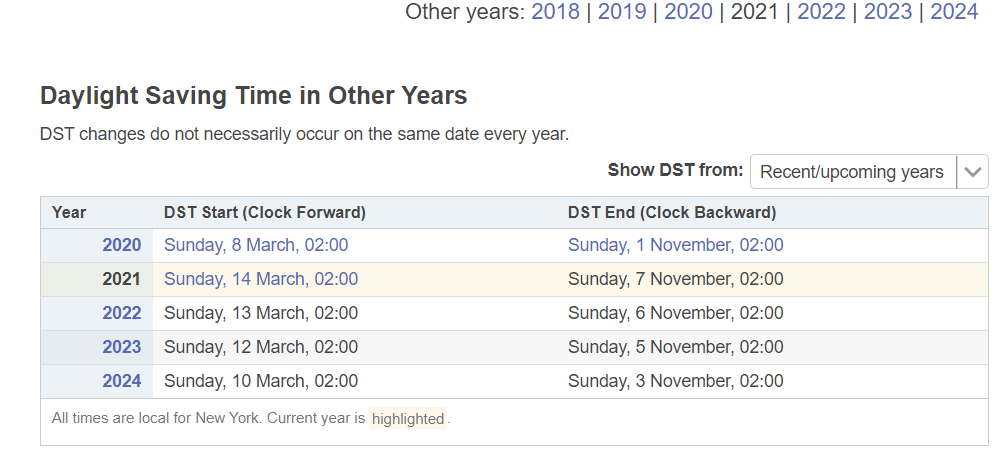

In [30]:
Image.open('C:\\Users\\Dell\\Desktop\\Work\\daylightSaving.png')


In [31]:
clockBackStart = date(2020, 11, 1)
clockBackEnd = date(2021, 3, 13)
clockForwardEnd = date(2021, 11, 7)

In [32]:
hours = ['WorkingHoursFrom', 'WorkingHoursTo', 'DeliveryHoursFrom', 'DeliveryHoursTo']

In [33]:
for i in range(len(data1)):
    for j in days:
        for k in hours:
            if df[j + k][i] != '':
                try:
                    if (clockBackStart <= datetime.strptime(df[j + k][i], "%Y-%m-%dT%H:%M:%S.%fZ").date() <= clockBackEnd):
                        df[j + k][i] = (datetime.strptime(df[j + k][i], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(hours = -5)).time().strftime('%H:%M')
                    elif (clockBackEnd < datetime.strptime(df[j + k][i], "%Y-%m-%dT%H:%M:%S.%fZ").date() < clockForwardEnd):
                        df[j + k][i] = (datetime.strptime(df[j + k][i], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(hours = -4)).time().strftime('%H:%M')
                    else:
                        df[j + k + 'AnotherDatetimeFormat'][i] = 'anotherDaylightSavingTimePeriod'
                except:
                    df[j + k + 'AnotherDatetimeFormat'][i] = 'another datetime format'

In [34]:
addressParts = ["streetAddress", "lat", "lon", "zip", "city", "state", "country"]

In [35]:
for i in range(len(data1)):
    for k in addressParts:
        if k in json.loads(data1['points'][i])[0]['address']:
            df[k][i] = json.loads(data1['points'][i])[0]['address'][k]
        else:
            df[k][i] = ''

### Consignees with 2 or more addresses

In [36]:
data2 = data[data['consigneesCount'] > 1]
data2.index = range(len(data2))

In [37]:
df.shape, data1.shape, data2.shape

((3397, 76), (2817, 15), (183, 15))

In [38]:
data1.shape[0] + data2.shape[0]

3000

In [39]:
ind = data1.shape[0]
for i in range(len(data2)):
    addressCount = len(json.loads(data2['points'][i]))
    indices = list(range(ind, ind + addressCount))
    for l in range(addressCount):
        df['id'][indices[l]] = data2['id'][i]
        df['name'][indices[l]] = data2['name'][i]
        df['companyLegalName'][indices[l]] = data2['companyLegalName'][i]
        df['email'][indices[l]] = data2['email'][i]
        df['phone1'][indices[l]] = data2['phone1'][i]
        df['phone2'][indices[l]] = data2['phone2'][i]
        df['contactPerson'][indices[l]] = data2['contactPerson'][i]
        df['rating'][indices[l]] = data2['rating'][i]
        df['notes'][indices[l]] = data2['notes'][i]
        df['mustbefirst'][indices[l]] = data2['mustbefirst'][i]
        df['driver'][indices[l]] = data2['driverId'][i]
        df['zone'][indices[l]] = data2['czone_id'][i]
        df['depot'][indices[l]] = data2['depo_id'][i]
    ind += addressCount

In [40]:
ind = data1.shape[0]
for i in range(len(data2)):
    addressCount = len(json.loads(data2['points'][i]))
    indices = list(range(ind, ind + addressCount))
    for l in range(addressCount):
        for j in days:
            if j in json.loads(data2['points'][i])[l]:
                if 'workingHours' in json.loads(data2['points'][i])[l][j]:
                    df[j + 'WorkingHoursFrom'][indices[l]] = json.loads(data2['points'][i])[l][j]['workingHours']['from']
                    df[j + 'WorkingHoursTo'][indices[l]] = json.loads(data2['points'][i])[l][j]['workingHours']['to']
                else:
                    df[j + 'WorkingHoursFrom'][indices[l]] = ''
                    df[j + 'WorkingHoursTo'][indices[l]] = ''
                if 'deliveryHours' in json.loads(data2['points'][i])[l][j]:
                    df[j + 'DeliveryHoursFrom'][indices[l]] = json.loads(data2['points'][i])[l][j]['deliveryHours']['from']
                    df[j + 'DeliveryHoursTo'][indices[l]] = json.loads(data2['points'][i])[l][j]['deliveryHours']['to']    
                else:
                    df[j + 'DeliveryHoursFrom'][indices[l]] = ''
                    df[j + 'DeliveryHoursTo'][indices[l]] = '' 
    ind += addressCount

In [41]:
addressParts

['streetAddress', 'lat', 'lon', 'zip', 'city', 'state', 'country']

In [42]:
ind = data1.shape[0]
for i in range(len(data2)):
    addressCount = len(json.loads(data2['points'][i]))
    indices = list(range(ind, ind + addressCount))
    for l in range(addressCount):
        if 'address' in json.loads(data2['points'][i])[l]:
            for k in addressParts:
                if k in json.loads(data2['points'][i])[l]['address']:
                    df[k][indices[l]] = json.loads(data2['points'][i])[l]['address'][k]
    ind += addressCount

In [43]:
for i in range(data1.shape[0], df.shape[0]):
    for j in days:
        for k in hours:
            if df[j + k][i] != '':
                try:
                    if (clockBackStart <= datetime.strptime(df[j + k][i], "%Y-%m-%dT%H:%M:%S.%fZ").date() <= clockBackEnd):
                        df[j + k][i] = (datetime.strptime(df[j + k][i], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(hours = -5)).time().strftime('%H:%M')
                    elif (clockBackEnd < datetime.strptime(df[j + k][i], "%Y-%m-%dT%H:%M:%S.%fZ").date() < clockForwardEnd):
                        df[j + k][i] = (datetime.strptime(df[j + k][i], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(hours = -4)).time().strftime('%H:%M')
                    else:
                        df[j + k + 'AnotherDatetimeFormat'][i] = 'anotherDaylightSavingTimePeriod'
                except:
                    df[j + k + 'AnotherDatetimeFormat'][i] = 'another datetime format'

### Here comes the part of 'another datetime formats' and 'anotherDaylightSavingTimePeriod'

In [44]:
days

['Friday', 'Monday', 'Sunday', 'Tuesday', 'Saturday', 'Thursday', 'Wednesday']

In [45]:
hours

['WorkingHoursFrom', 'WorkingHoursTo', 'DeliveryHoursFrom', 'DeliveryHoursTo']

In [46]:
for i in days:
    for m in hours:
        if (('another datetime format' not in df[i + m + 'AnotherDatetimeFormat'].unique()) and ('anotherDaylightSavingTimePeriod' not in df[i + m + 'AnotherDatetimeFormat'].unique())):
            df = df.drop([i + m + 'AnotherDatetimeFormat'], axis = 1)

In [47]:
df.columns

Index(['id', 'name', 'companyLegalName', 'email', 'phone1', 'phone2',
       'contactPerson', 'rating', 'notes', 'mustbefirst', 'driver', 'zone',
       'depot', 'lat', 'lon', 'zip', 'city', 'state', 'country',
       'streetAddress', 'FridayWorkingHoursFrom', 'FridayWorkingHoursTo',
       'FridayDeliveryHoursFrom', 'FridayDeliveryHoursTo',
       'MondayWorkingHoursFrom', 'MondayWorkingHoursTo',
       'MondayDeliveryHoursFrom', 'MondayDeliveryHoursTo',
       'SundayWorkingHoursFrom', 'SundayWorkingHoursTo',
       'SundayDeliveryHoursFrom', 'SundayDeliveryHoursTo',
       'TuesdayWorkingHoursFrom', 'TuesdayWorkingHoursTo',
       'TuesdayDeliveryHoursFrom', 'TuesdayDeliveryHoursTo',
       'SaturdayWorkingHoursFrom', 'SaturdayWorkingHoursTo',
       'SaturdayDeliveryHoursFrom', 'SaturdayDeliveryHoursTo',
       'ThursdayWorkingHoursFrom', 'ThursdayWorkingHoursTo',
       'ThursdayDeliveryHoursFrom', 'ThursdayDeliveryHoursTo',
       'WednesdayWorkingHoursFrom', 'WednesdayWorkingHou

In [50]:
for i in days:
    for m in hours:
        if ('anotherDaylightSavingTimePeriod' in df[i + m + 'AnotherDatetimeFormat'].unique()):
            print(i + m + 'AnotherDatetimeFormat')

In [51]:
for i in days:
    for m in hours:
        if (i + m + 'AnotherDatetimeFormat') in df.columns:
            indicesOfAnotherDatetimeFormat = df[df[i + m + 'AnotherDatetimeFormat'] == 'another datetime format'].index
            for l in indicesOfAnotherDatetimeFormat:
                try:
                    if (clockBackStart <= datetime.strptime(df.iloc[l][i + m], "%Y-%m-%dT%H:%M:%SZ").date() <= clockBackEnd):
                        df.iloc[l][i + m] = (datetime.strptime(df.iloc[l][i + m], "%Y-%m-%dT%H:%M:%SZ") + timedelta(hours = -5)).time().strftime('%H:%M')
                        df.iloc[l][i + m + 'AnotherDatetimeFormat'] = ''
                    if (clockBackEnd < datetime.strptime(df.iloc[l][i + m], "%Y-%m-%dT%H:%M:%SZ").date() < clockForwardEnd):
                        df.iloc[l][i + m] = (datetime.strptime(df.iloc[l][i + m], "%Y-%m-%dT%H:%M:%SZ") + timedelta(hours = -4)).time().strftime('%H:%M')
                        df.iloc[l][i + m + 'AnotherDatetimeFormat'] = ''
                    else:
                        df.iloc[l][i + m + 'AnotherDatetimeFormat'] = 'anotherDaylightSavingTimePeriod'
                except:
                    df.iloc[l][i + m + 'AnotherDatetimeFormat'] = 'another datetime format'
                    
                

In [52]:
for i in days:
    for m in hours:
        if (i + m + 'AnotherDatetimeFormat') in df.columns:
            if (('another datetime format' not in df[i + m + 'AnotherDatetimeFormat'].unique()) and ('anotherDaylightSavingTimePeriod' not in df[i + m + 'AnotherDatetimeFormat'].unique())):
                df = df.drop([i + m + 'AnotherDatetimeFormat'], axis = 1)

In [53]:
df.columns

Index(['id', 'name', 'companyLegalName', 'email', 'phone1', 'phone2',
       'contactPerson', 'rating', 'notes', 'mustbefirst', 'driver', 'zone',
       'depot', 'lat', 'lon', 'zip', 'city', 'state', 'country',
       'streetAddress', 'FridayWorkingHoursFrom', 'FridayWorkingHoursTo',
       'FridayDeliveryHoursFrom', 'FridayDeliveryHoursTo',
       'MondayWorkingHoursFrom', 'MondayWorkingHoursTo',
       'MondayDeliveryHoursFrom', 'MondayDeliveryHoursTo',
       'SundayWorkingHoursFrom', 'SundayWorkingHoursTo',
       'SundayDeliveryHoursFrom', 'SundayDeliveryHoursTo',
       'TuesdayWorkingHoursFrom', 'TuesdayWorkingHoursTo',
       'TuesdayDeliveryHoursFrom', 'TuesdayDeliveryHoursTo',
       'SaturdayWorkingHoursFrom', 'SaturdayWorkingHoursTo',
       'SaturdayDeliveryHoursFrom', 'SaturdayDeliveryHoursTo',
       'ThursdayWorkingHoursFrom', 'ThursdayWorkingHoursTo',
       'ThursdayDeliveryHoursFrom', 'ThursdayDeliveryHoursTo',
       'WednesdayWorkingHoursFrom', 'WednesdayWorkingHou

### Collecting final file

In [54]:
for i in days:
    df[i + ' Working Hours'] = ''
    df[i + ' Delivery Hours'] = ''

In [55]:
for i in range(len(df)):
    for j in days:
        df[j + ' Working Hours'][i] = str(df[j + 'WorkingHoursFrom'][i]) + ' - ' + str(df[j + 'WorkingHoursTo'][i])
        df[j + ' Delivery Hours'][i] = str(df[j + 'DeliveryHoursFrom'][i]) + ' - ' + str(df[j + 'DeliveryHoursTo'][i])

In [56]:
for i in range(len(df)):
    for j in days:
        if df[j + ' Working Hours'][i] == ' - ':
            df[j + ' Working Hours'][i] = np.nan
        if df[j + ' Delivery Hours'][i] == ' - ':
            df[j + ' Delivery Hours'][i] = np.nan

In [57]:
for i in days:
    for m in hours:
        df = df.drop([i + m], axis = 1)

In [58]:
set(df['depot'][~pd.isnull(df['depot'])])

{4.0, 5.0}

In [59]:
for i in range(len(df)):
    if df['depot'][i] == 4:
        df['depot'][i] = 'SouthDepot'
    elif df['depot'][i] == 5:
        df['depot'][i] = 'NorthDepot'

In [60]:
queryForZone = 'SELECT `id`, `name` FROM `czones`'
try:
    mycursor.execute(queryForZone)
except:
    print('Execute Failed')
zones = mycursor.fetchall()

In [61]:
zone = pd.DataFrame(zones, columns = ['id', 'name'])

In [62]:
zone

,id,name
0,1,MARYLAND AREA
1,2,Bel Air Rd
2,3,Cecil
3,4,North Harford
4,5,Bel Air/Aberdeen/HdG
5,6,Baltimore City/Rosedale
6,7,Glen Burnie/Dundalk
7,8,83/Timonium/Westminster
8,9,Anne Arundle County
9,10,Zone 1 (North)


In [63]:
for i in range(len(df)):
    if not np.isnan(df['zone'][i]):
        b = df['zone'][i]
        k = zone[zone['id'] == b].index[0]
        df['zone'][i] = zone[zone['id'] == b]['name'][k]

In [64]:
data['driverId'].unique()

array([nan,  0., 34.])

In [65]:
for i in range(len(df)):
    if df['driver'][i] == 34:
        df['driver'][i] = 'Karl Diamond'
    elif df['driver'][i] == 0:
        df['driver'][i] = np.nan

In [1]:
# df

In [69]:
df = df[['id', 'name', 'companyLegalName', 'email', 'phone1', 'phone2',
       'contactPerson', 'rating', 'notes', 'mustbefirst', 'driver', 'zone',
       'depot', 'lat', 'lon', 'zip', 'city', 'state', 'country',
       'streetAddress', 'Monday Working Hours', 'Monday Delivery Hours', 'Tuesday Working Hours',
       'Tuesday Delivery Hours', 'Wednesday Working Hours',
       'Wednesday Delivery Hours', 'Thursday Working Hours',
       'Thursday Delivery Hours', 'Friday Working Hours', 'Friday Delivery Hours', 'Saturday Working Hours',
       'Saturday Delivery Hours', 'Sunday Working Hours',
       'Sunday Delivery Hours']]

In [70]:
df.to_excel("C:\\Users\\Dell\\Desktop\\CustomersNew.xlsx")